In [27]:
from bioinf_learn import MinHash
from bioinf_learn import WtaHash

%matplotlib inline
%load_ext memory_profiler
from bioinf_learn.util import measureCpuScalability
from bioinf_learn.util import measureCpuScalability_Gpu
from bioinf_learn.util import plotDataBenchmark
from bioinf_learn.util import plotData
from bioinf_learn.util import measureMinHashWtaHash
import time
import numpy as np

from eden.converter.graph.gspan import gspan_to_eden
from eden.graph import Vectorizer

from eden.converter.rna.rnafold import rnafold_to_eden
from eden.converter.fasta import fasta_to_sequence
from eden.graph import Vectorizer
from itertools import islice
import numpy as np
from scipy.sparse import vstack


import time
import numpy as np
def rfam_uri(family_id):
    return 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id)

def rfam_to_matrix(rfam_id, n_max=50, complexity=2, nbits=10):
    seqs = fasta_to_sequence(rfam_uri(rfam_id))
    seqs = islice(seqs,n_max)
    seqs = list(seqs)
    graphs = rnafold_to_eden(seqs)
    vectorizer = Vectorizer(complexity=complexity, nbits=nbits, positional=True)
    X = vectorizer.transform(graphs)
    return X

def rfam_data(rfam_ids, n_max=300, complexity=3, nbits=13):
    Xs = []
    targets = []
    for i,rfam_id in enumerate(rfam_ids):
        X=rfam_to_matrix(rfam_id, n_max=n_max, complexity=complexity, nbits=nbits)
        Xs.append(X)
        targets += [i] * X.shape[0]
    data_matrix = vstack(Xs, format="csr")
    targets = np.array(targets)    
    return data_matrix, targets

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [2]:
graphs = gspan_to_eden( 'http://www.bioinf.uni-freiburg.de/~costa/bursi.gspan' )
vectorizer = Vectorizer( r=2,d=5 )

%time %memit datasetBursi = vectorizer.transform( graphs )

peak memory: 497.73 MiB, increment: 387.21 MiB
CPU times: user 35.5 s, sys: 152 ms, total: 35.6 s
Wall time: 36.7 s


In [28]:
rfam_ids=['RF00004','RF00005','RF00015','RF00020','RF00026','RF00169',
          'RF00380','RF00386','RF01051','RF01055','RF01234','RF01699',
          'RF01701','RF01705','RF01731','RF01734','RF01745','RF01750',
          'RF01942','RF01998','RF02005','RF02012','RF02034']

%time %memit datasetRNA, y = rfam_data(rfam_ids, n_max=100, complexity=3, nbits=16)
print 'Instances: %d Features: %d with an avg of %d features per instance' % (datasetRNA.shape[0], datasetRNA.shape[1],  datasetRNA.getnnz()/datasetRNA.shape[0])
print "Sparsity: ", datasetRNA.nnz / float(datasetRNA.shape[0]) / datasetRNA.shape[1]

peak memory: 665.29 MiB, increment: 129.64 MiB
CPU times: user 1min 38s, sys: 59.3 s, total: 2min 37s
Wall time: 3min 24s
Instances: 2300 Features: 65537 with an avg of 3676 features per instance
Sparsity:  0.0560959059967


In [3]:
max_bin_size = 49
shingle_size = 2
minimal_blocks_in_common= 1
prune_inverse_index= 11
store_value_with_least_sigificant_bit=3
excess_factor= 11
prune_inverse_index_after_instance= 0.5
remove_hash_function_with_less_entries_as= 0
shingle= 0
block_size= 4
hash_functions = 596
minHash = [max_bin_size, shingle_size, minimal_blocks_in_common, prune_inverse_index, 
            store_value_with_least_sigificant_bit, excess_factor,
            prune_inverse_index_after_instance, remove_hash_function_with_less_entries_as,
            shingle, block_size, hash_functions]
cpu_cores = [1, 2, 4, 8, 12, 16, 20, 24, 28, 32]

In [ ]:
cpu_cores = [1, 2, 4, 8, 12, 16, 20, 24, 28, 32]
cpu_scalability_xeon = measureCpuScalability(datasetBursi, minHash, cpu_cores)

In [ ]:
cpu_cores = [1, 2, 4, 8, 12, 16, 20, 24, 28, 32]
cpu_scalability_xeon_980Ti = measureCpuScalability_Gpu(datasetBursi, minHash, cpu_cores)

In [8]:
cpu_cores = [1, 2, 4]
cpu_scalability_i5_5200U = measureCpuScalability(datasetBursi, minHash, cpu_cores)

In [5]:
print cpu_scalability_i5_5200U

[[9.228111982345581, 4.981896162033081, 4.456392049789429], [4.089432954788208, 4.870645999908447, 3.817233085632324], [5.996991872787476, 3.311551094055176, 2.3043200969696045], [0.8975328568134655, 0.8975328568134655, 0.8975328568134655]]


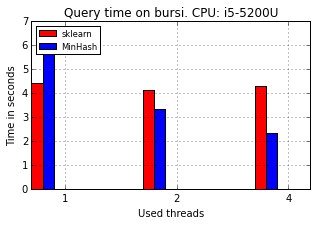

In [26]:

plotData(data=cpu_scalability_i5_5200U[1:3], color=["r", "b"], label=["sklearn", "MinHash"],
        xticks=["1", "2", "4"], ylabel="Time in seconds", number_of_instances=3,
        xlabel="Used threads", log = False, figure_size=(5, 3),
         number_of_features=1, title='Query time on bursi. CPU: i5-5200U')

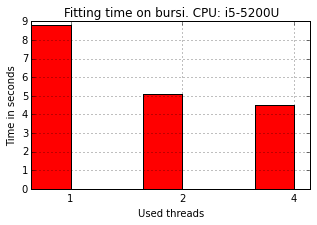

In [25]:
plotDataBenchmark(data=cpu_scalability_i5_5200U[0], color=["r"], 
         label=[],
        xticks=["1", "2", "4"],
         ylabel="Time in seconds", number_of_instances=3, bar_width=0.35, figure_size=(5, 3),
        xlabel="Used threads", log = False,
         number_of_features=1, title='Fitting time on bursi. CPU: i5-5200U')

In [4]:
cpu_cores = [1, 2, 4]
cpu_gpu_scalability_i5_5200U = measureCpuScalability_Gpu(datasetBursi, minHash, cpu_cores)

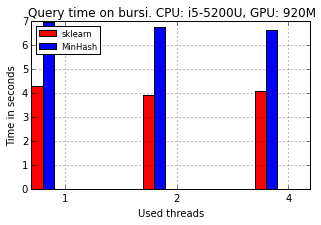

In [24]:
from bioinf_learn.util import plotData
plotData(data=cpu_gpu_scalability_i5_5200U[1:3], color=["r", "b"], label=["sklearn", "MinHash"],
        xticks=["1", "2", "4"], ylabel="Time in seconds", number_of_instances=3,
        xlabel="Used threads", log = False, figure_size=(5, 3),
         number_of_features=1, title='Query time on bursi. CPU: i5-5200U, GPU: 920M')

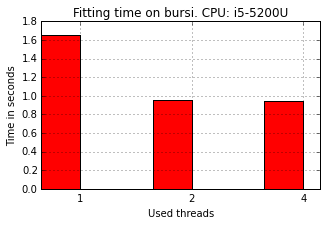

In [23]:
plotDataBenchmark(data=cpu_gpu_scalability_i5_5200U[0], color=["r"], 
         label=[],
        xticks=["1", "2", "4"],
         ylabel="Time in seconds", number_of_instances=3, bar_width=0.35, figure_size=(5, 3),
        xlabel="Used threads", log = False,
         number_of_features=1, title='Fitting time on bursi. CPU: i5-5200U')

### RNA dataset

In [36]:
max_bin_size = 89
shingle_size = 2
minimal_blocks_in_common= 1
prune_inverse_index= 8
store_value_with_least_sigificant_bit=3
excess_factor= 14
prune_inverse_index_after_instance= 0.5
remove_hash_function_with_less_entries_as= 0
shingle= 0
block_size= 4
hash_function = 660
minHash = [max_bin_size, shingle_size, minimal_blocks_in_common, prune_inverse_index, 
            store_value_with_least_sigificant_bit, excess_factor,
            prune_inverse_index_after_instance, remove_hash_function_with_less_entries_as,
            shingle, block_size, hash_functions]

In [37]:
cpu_cores = [1, 2, 4]
cpu_scalability_i5_5200U_rna = measureCpuScalability(datasetRNA, minHash, cpu_cores)

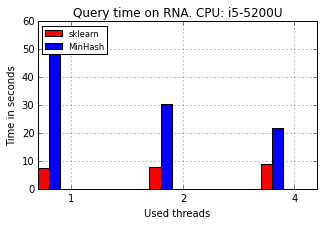

In [38]:
plotData(data=cpu_scalability_i5_5200U_rna[1:3], color=["r", "b"], label=["sklearn", "MinHash"],
        xticks=["1", "2", "4"], ylabel="Time in seconds", number_of_instances=3,
        xlabel="Used threads", log = False, figure_size=(5, 3),
         number_of_features=1, title='Query time on RNA. CPU: i5-5200U')

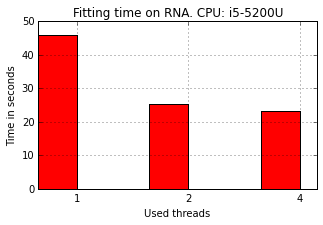

In [39]:
plotDataBenchmark(data=cpu_scalability_i5_5200U_rna[0], color=["r"], 
         label=[],
        xticks=["1", "2", "4"],
         ylabel="Time in seconds", number_of_instances=3, bar_width=0.35, figure_size=(5, 3),
        xlabel="Used threads", log = False,
         number_of_features=1, title='Fitting time on RNA. CPU: i5-5200U')

In [40]:
cpu_cores = [1, 2, 4]
cpu_gpu_scalability_i5_5200U_rna = measureCpuScalability_Gpu(datasetRNA, minHash, cpu_cores)

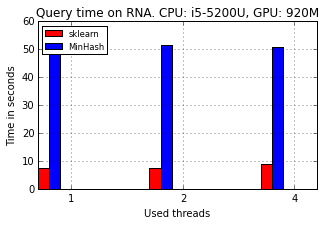

In [41]:
plotData(data=cpu_gpu_scalability_i5_5200U_rna[1:3], color=["r", "b"], label=["sklearn", "MinHash"],
        xticks=["1", "2", "4"], ylabel="Time in seconds", number_of_instances=3,
        xlabel="Used threads", log = False, figure_size=(5, 3),
         number_of_features=1, title='Query time on RNA. CPU: i5-5200U, GPU: 920M')

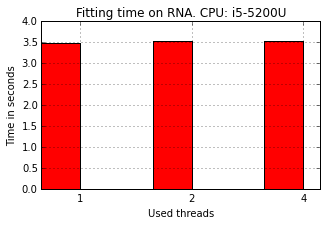

In [42]:
plotDataBenchmark(data=cpu_gpu_scalability_i5_5200U_rna[0], color=["r"], 
         label=[],
        xticks=["1", "2", "4"],
         ylabel="Time in seconds", number_of_instances=3, bar_width=0.35, figure_size=(5, 3),
        xlabel="Used threads", log = False,
         number_of_features=1, title='Fitting time on RNA. CPU: i5-5200U')